Repetir o gráfico:
- Categorias que vendem mais em cada mês.
usando o clip(0,20)

A linha que monta a entrada da LSTM

In [1]:
#a = df_clean[['date_block_num', 'shop_id', 'item_id','city_code', 'revenue', 'item_cnt_day']]
#a.pivot_table(index=['shop_id', 'item_id', 'city_code'], columns=['date_block_num'], values=['item_cnt_day','revenue'], aggfunc='sum', fill_value=0).stack()[0:33]

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

path = 'data'

train = pd.read_csv(path + '/sales_train.csv.gz')
test = pd.read_csv(path + '/test.csv.gz').set_index('ID')
items = pd.read_csv(path + '/items.csv')
items_cat = pd.read_csv(path + '/item_categories.csv')
shops = pd.read_csv(path + '/shops.csv')
geo = pd.read_csv(path + '/geo_shop.csv')

Using TensorFlow backend.


In [3]:
df_train_month = pd.read_pickle('df_train_month_lag5.pkl')

df_train_month.head()

,shop_id,item_id,date_block_num,item_cnt_month_lag(-1),item_cnt_month_lag(-2),item_cnt_month_lag(-3),item_cnt_month_lag(-4),item_cnt_month_lag(-5),item_cnt_month_lag(0),mean_item_cnt_per_category_lag(-1),...,revenue_month_lag(-4),revenue_month_lag(-5),revenue_month_lag(0),item_category_id,type_code,subtype_code,city_code,latitude,longitude,is_online
5,0,30,5,0,0,0,31,0,0,0.0,...,8215.0,0.0,0.0,40,11,4,29,62.035454,129.675476,0
6,0,30,6,0,0,0,0,31,0,0.0,...,0.0,8215.0,0.0,40,11,4,29,62.035454,129.675476,0
7,0,30,7,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,40,11,4,29,62.035454,129.675476,0
8,0,30,8,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,40,11,4,29,62.035454,129.675476,0
9,0,30,9,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,40,11,4,29,62.035454,129.675476,0


In [4]:
df_train_month.iloc[:,3:7] = df_train_month.iloc[:,3:7].clip(0,20)

In [5]:
def fit_column_scaler_min_max(minval, maxval, dataframe):
    
    columns = dataframe.columns
    
    scaler = { column : MinMaxScaler(feature_range=(minval, maxval))
              for column in columns}
    
    scaler_fit = [scaler[column].fit_transform(dataframe[[column]]).astype(np.float32)
                  for column in columns]
    
    for idx, column in enumerate(columns):
        dataframe[column] = scaler_fit[idx]
        
    return dataframe, scaler

In [6]:
def inv_column_scaler_min_max(scaler_data, dataframe):
    
    columns = dataframe.columns
    
    scaler_inv = [scaler_data[column].inverse_transform(dataframe[[column]])
                  for column in columns]
        
    for idx, column in enumerate(columns):
        dataframe[column] = scaler_inv[idx]
        
    return dataframe

In [7]:
t = df_train_month['date_block_num']
time_steps = t.max() - t.min()

del t

In [8]:
df_train_month, scaler = fit_column_scaler_min_max(-1, 1, df_train_month)

/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int8 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int16 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int8 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int16 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-p

/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/ronaldo/anaconda3/envs/Data_Science/lib/python

In [9]:
df_train_month['date_block_num'] = inv_column_scaler_min_max(scaler, df_train_month[['date_block_num']]).astype(np.int16)

/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [10]:
features = df_train_month.shape[1] - 2 # date_block_num e item_cnt_lag(0) não vão entrar.
n_samples = int(df_train_month.shape[0] / (time_steps + 1) ) # +1 é porque ainda não retirei o mês 33

'Time:', time_steps, 'Features:', features, 'Samples:', n_samples

('Time:', 28, 'Features:', 50, 'Samples:', 424124)

In [11]:
x_train = df_train_month[df_train_month.date_block_num != 33].drop(['date_block_num', 'item_cnt_month_lag(0)'], axis=1).values
y_train = df_train_month.loc[df_train_month.date_block_num == 33, 'item_cnt_month_lag(0)'].values

In [12]:
x_train = x_train.reshape((n_samples, time_steps, features))

In [13]:
x_train.shape, y_train.shape

((424124, 28, 50), (424124,))

In [14]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(time_steps, features)))#, return_sequences=True))
model.add(Dropout(0.5))
#model.add(LSTM(units=64, input_shape=(time_step1, features1)))
#model.add(Dropout(0.5))
model.add(Dense(1))

In [15]:
model.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 29,505
Trainable params: 29,505
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(x_train, y_train, batch_size = 4096, epochs = 5, shuffle=False)

Epoch 1/5
424124/424124 [==============================] - 36s 84us/step - loss: 0.0446 - mean_squared_error: 0.0446
Epoch 2/5
424124/424124 [==============================] - 35s 81us/step - loss: 0.0182 - mean_squared_error: 0.0182
Epoch 3/5
424124/424124 [==============================] - 37s 87us/step - loss: 0.0151 - mean_squared_error: 0.0151
Epoch 4/5
424124/424124 [==============================] - 35s 84us/step - loss: 0.0139 - mean_squared_error: 0.0139
Epoch 5/5
424124/424124 [==============================] - 35s 82us/step - loss: 0.0130 - mean_squared_error: 0.0130


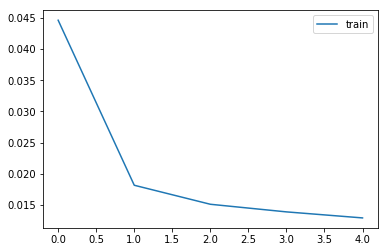

In [18]:
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history[''], label='train')
plt.legend()
plt.show()

In [20]:
import gc

del x_train
del y_train

gc.collect()

NameError: name 'x_train' is not defined

In [22]:
pred = df_train_month[df_train_month.date_block_num != 5].drop(['date_block_num', 'item_cnt_month_lag(0)'], axis=1).values
pred = pred.reshape((n_samples, time_steps, features))
yhat = model.predict(pred)

del pred

In [23]:
df_test = df_train_month[df_train_month.date_block_num == 33][['shop_id', 'item_id']]
df_test['item_cnt_month_lag(0)'] = yhat
df_test.head()

,shop_id,item_id,item_cnt_month_lag(0)
33,-1.0,-0.997294,-1.024443
67,-1.0,-0.997203,-1.024339
101,-1.0,-0.997113,-1.024445
135,-1.0,-0.997023,-1.024340
169,-1.0,-0.996842,-1.024447


In [24]:
df_test = inv_column_scaler_min_max(scaler, df_test[['shop_id', 'item_id', 'item_cnt_month_lag(0)']])
df_test.head()

,shop_id,item_id,item_cnt_month_lag(0)
33,0.0,29.999846,-49.804218
67,0.0,31.000127,-49.685297
101,0.0,31.999747,-49.805981
135,0.0,33.000028,-49.687059
169,0.0,34.999930,-49.808557


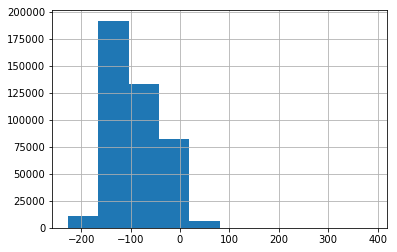

In [25]:
df_test['item_cnt_month_lag(0)'].hist()

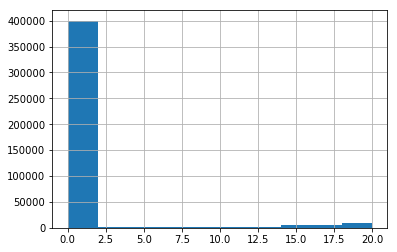

In [26]:
df_test['item_cnt_month_lag(0)'] = df_test['item_cnt_month_lag(0)'].clip(0,20)
df_test = np.around(df_test).astype(np.int16)
df_test['item_cnt_month_lag(0)'].hist()

In [27]:
df_sub = pd.merge(test, df_test, on=['shop_id', 'item_id'], how='left').fillna(0)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": df_sub['item_cnt_month_lag(0)']
})

#submission.to_csv('LSTM_submission.csv', index=False)

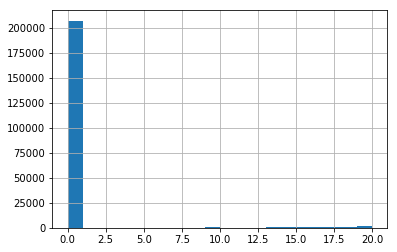

In [28]:
df_sub['item_cnt_month_lag(0)'].hist(bins=20)

In [21]:
quit()

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.
